In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline,make_pipeline 
from sklearn.metrics import mean_squared_error
from hypopt import GridSearch
import xgboost as xgb
import pickle
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin,RegressorMixin
from sklearn.model_selection import cross_val_score,cross_val_predict, KFold,train_test_split,GridSearchCV,RandomizedSearchCV

In [41]:
x=np.array([2, 3, datetime.strptime('2020-8-9',
                                  "%Y-%m-%d").date()])
# pd.DataFrame(x, columns=['a'])
y=x.reshape(1,3)
pd.DataFrame(y, columns=['a', "b", "c"])

,a,b,c
0,2,3,2020-08-09


In [42]:
na_value=['',' ','nan','Nan','NaN','na']
train=pd.read_csv('../../datasets/rossmann-store-sales/train.csv',na_values=na_value)
store=pd.read_csv('../../datasets/rossmann-store-sales/store.csv',na_values=na_value)
test=pd.read_csv('../../datasets/rossmann-store-sales/test.csv',na_values=na_value)

/home/patrick/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [43]:
# fillna in store with 0 has better result than median()
store.fillna(0, inplace=True)
test.fillna(value = 1, inplace = True)

In [44]:
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

In [45]:
# split the last 6 weeks data as hold-out set (idea from Gert https://www.kaggle.com/c/rossmann-store-sales/discussion/18024)
train = train.sort_values(['Date'],ascending = False)
train_total = train.copy()

split_index = 6*7*1115
valid = train[:split_index] 
train = train[split_index:]

# only use data of Sales>0 and Open is 1
valid = valid[(valid.Open != 0)&(valid.Sales >0)]
train = train[(train.Open != 0)&(train.Sales >0)]
train_total = train_total[(train_total.Open != 0)&(train_total.Sales >0)]


In [46]:
train.StoreType.unique()

array(['a', 'c', 'd', 'b'], dtype=object)

In [13]:
test

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,857,1,3,2015-09-16,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1713,1,2,2015-09-15,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,2569,1,1,2015-09-14,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,3425,1,7,2015-09-13,0.0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,37664,1115,3,2015-08-05,1.0,1,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
41084,38520,1115,2,2015-08-04,1.0,1,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
41085,39376,1115,1,2015-08-03,1.0,1,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
41086,40232,1115,7,2015-08-02,0.0,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [24]:
def process(data, isTest = False):
    # label encode some features
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    # extract some features from date column  
    data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)
    data['Month'] = data.Date.dt.month
    data['Year'] = data.Date.dt.year
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    # calculate competiter open time in months
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)
    
    # calculate promo2 open time in months
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)
                                                 
    # Indicate whether the month is in promo interval
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['month_str'] = data.Month.map(month2str)

    def check(row):
        if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
            return 1
        else:
            return 0
        
    data['IsPromoMonth'] =  data.apply(lambda row: check(row),axis=1)    
    
    # select the features we need
    features = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']  
    if not isTest:
        features.append('Sales')
        
    data = data[features]
    return data

train = process(train)
valid = process(valid)
train_total = process(train_total)
x_test = process(test,isTest = True)

In [25]:
# sort by index
valid.sort_index(inplace = True)
train.sort_index(inplace = True)
train_total.sort_index(inplace = True)

# split x and y
x_train, y_train = train.drop(columns = ['Sales']), np.log1p(train['Sales'])
x_valid, y_valid = valid.drop(columns = ['Sales']), np.log1p(valid['Sales'])
x_train_total, y_train_total = train_total.drop(columns = ['Sales']), np.log1p(train_total['Sales'])

In [26]:
# define eval metrics
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [27]:
clf = RandomForestRegressor(n_estimators = 15)
clf.fit(x_train, y_train)
# validation
y_pred = clf.predict(x_valid)
error = rmspe(np.expm1(y_valid), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

RMSPE: 0.1592


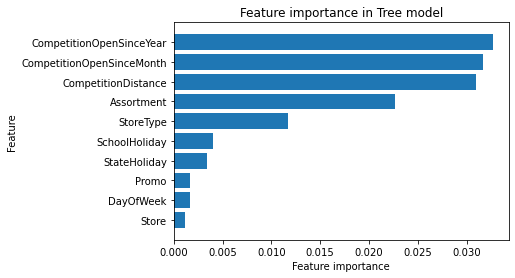

In [37]:
def plot_feature_importances(model,name):
    feature=pd.DataFrame({'imp':model.feature_importances_,'features':x_train.columns})
    feature=feature.sort_values(by='imp',ascending = True).head(10)
    n_features =feature.shape[0]
    plt.barh(range(n_features),feature.imp, align='center')
    plt.yticks(np.arange(n_features), x_train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.title('Feature importance in Tree model')
    plt.savefig(name+'.jpg')
    return feature.features.values
features=plot_feature_importances(clf,'feature_importance')

In [29]:
params = {"objective": "reg:linear", # for linear regression
          "booster" : "gbtree",   # use tree based models 
          "eta": 0.03,   # learning rate
          "max_depth": 10,    # maximum depth of a tree
          "subsample": 0.9,    # Subsample ratio of the training instances
          "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
          "silent": 1,   # silent mode
          "seed": 10   # Random number seed
          }
num_boost_round = 4000

dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_valid, y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
# train the xgboost model
model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds= 100, feval=rmspe_xg, verbose_eval=True)

[22:52:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[22:52:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:8.02086	eval-rmse:8.02743	train-rmspe:0.99981	eval-rmspe:0.99981
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.78076	eval-rmse:7.78738	train-rmspe:0.99971	eval-rmspe:0.99971
[2]	train-rmse:7.54783	eval-rmse:7.55454	train-rmspe:0.99959	eval-rmspe:0.99960
[3]	train-rmse:7.32196	eval-rmse:7.32858	train-rmspe:

In [30]:
y_pred = model.predict(xgb.DMatrix(x_valid))
error = rmspe(np.expm1(y_valid), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

RMSPE: 0.1250


Best weight is 0.995, RMSPE is 0.1202


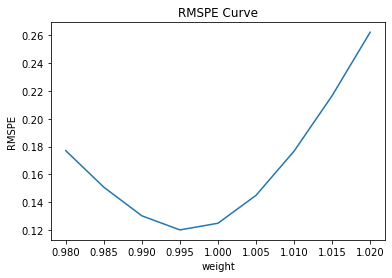

In [31]:
def correction():
    weights = np.arange(0.98, 1.02, 0.005)
    errors = []
    for w in weights:
        error = rmspe(np.expm1(y_valid), np.expm1(y_pred*w))
        errors.append(error)
        
    # make line plot
    plt.plot(weights, errors)
    plt.xlabel('weight')
    plt.ylabel('RMSPE')
    plt.title('RMSPE Curve')
    # print min error
    idx = errors.index(min(errors))
    print('Best weight is {}, RMSPE is {:.4f}'.format(weights[idx], min(errors)))
    
correction()

In [32]:
x_train_total.head().append(x_train_total.tail())

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
0,1,5,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,31,31,82.0,24187.75,0
1,1,4,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,30,31,82.0,24187.75,0
2,1,3,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,29,31,82.0,24187.75,0
3,1,2,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,28,31,82.0,24187.75,0
4,1,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,27,31,82.0,24187.75,0
1017202,1115,1,1,0,1,4,3,5350.0,0.0,0.0,1,22.0,2012.0,2013,1,7,2,24157.0,7.00,0
1017204,1115,6,0,0,1,4,3,5350.0,0.0,0.0,1,22.0,2012.0,2013,1,5,1,24157.0,6.75,0
1017205,1115,5,0,0,1,4,3,5350.0,0.0,0.0,1,22.0,2012.0,2013,1,4,1,24157.0,6.75,0
1017206,1115,4,0,0,1,4,3,5350.0,0.0,0.0,1,22.0,2012.0,2013,1,3,1,24157.0,6.75,0
1017207,1115,3,0,0,1,4,3,5350.0,0.0,0.0,1,22.0,2012.0,2013,1,2,1,24157.0,6.75,0


In [38]:
dtrain = xgb.DMatrix(x_train_total, y_train_total)
dtest = xgb.DMatrix(x_test)
# specify parameters via map
params = {"objective": "reg:linear", # for linear regression
          "booster" : "gbtree",   # use tree based models 
          "eta": 0.03,   # learning rate
          "max_depth": 10,    # maximum depth of a tree
          "subsample": 0.9,    # Subsample ratio of the training instances
          "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
          "silent": 1,   # silent mode
          "seed": 10   # Random number seed
          }
num_round = 1000
model = xgb.train(params, dtrain, num_round)
# make prediction
preds = model.predict(dtest)

[00:14:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:38:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


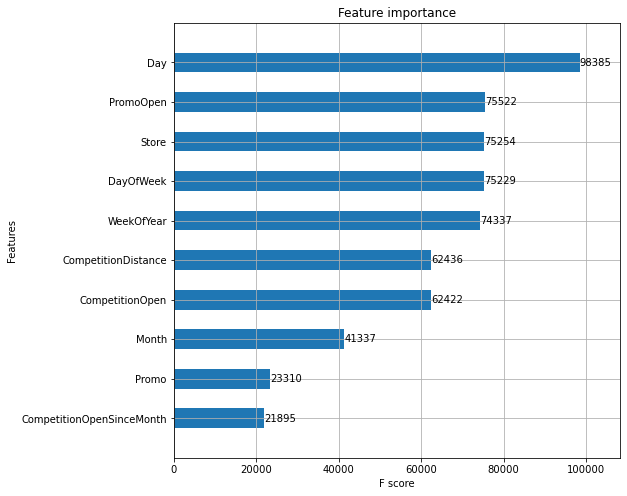

In [39]:
# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(model, max_num_features= 10, height=0.5, ax=ax)
plt.show()

In [ ]:
result = pd.DataFrame({"Id": test["Id"],'Sales': np.expm1(preds*0.995)})

Multiply the exponent of the predicted values with 0.995 

In [13]:
##One transformer for all
class Preprocessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, data, y=None):
        return self
    def check(self,row):
            if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
                return 1
            else:
                return 0

    def transform(self,data):
        self.cols=data.columns
        data = data.sort_values(['Date'],ascending = False)
        mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
        data.StoreType.replace(mappings, inplace=True)
        data.Assortment.replace(mappings, inplace=True)
        data.StateHoliday.replace(mappings, inplace=True)
    
        # extract some features from date column  
        data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)
        data['Month'] = data.Date.dt.month
        data['Year'] = data.Date.dt.year
        data['Day'] = data.Date.dt.day
        data['WeekOfYear'] = data.Date.dt.weekofyear
    
        # calculate competiter open time in months
        data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
            (data.Month - data.CompetitionOpenSinceMonth)
        data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)
    
        # calculate promo2 open time in months
        data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
            (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
        data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)
                                                 
        # Indicate whether the month is in promo interval
        month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
        data['month_str'] = data.Month.map(month2str)
        if 'Sales' in self.cols:
            data = data[(data.Open != 0)&(data.Sales >0)]
        data['IsPromoMonth'] =  data.apply(lambda row: self.check(row),axis=1)    
    
        # select the features we need
        features = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
           'StoreType', 'Assortment', 'CompetitionDistance',
           'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
           'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
           'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']  
        
        
        data = data[features]

        return data
        
        
        
        
       



In [24]:
class Regressor(BaseEstimator, RegressorMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        x_train_total, y_train_total = X, np.log1p(y)
        dtrain = xgb.DMatrix(x_train_total, y_train_total)
        # specify parameters via map
        params = {"objective": "reg:linear", # for linear regression
                  "booster" : "gbtree",   # use tree based models 
                  "eta": 0.03,   # learning rate
                  "max_depth": 10,    # maximum depth of a tree
                    "subsample": 0.9,    # Subsample ratio of the training instances
                    "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
                  "silent": 1,   # silent mode
                  "seed": 10   # Random number seed
          }
        num_round = 1000
        self.model = xgb.train(params, dtrain, num_round)
        return self
    
    def predict(self, X):
        dtest = xgb.DMatrix(X)
        return self.model.predict(dtest)

In [25]:
X,y=train.drop(['Sales'],axis=1),train['Sales']
pipe = Pipeline(steps=[('preprocesssing',Preprocessing()),('Reg',Regressor())])
pipe.fit(X,y)

[09:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:32:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('preprocesssing', Preprocessing()), ('Reg', Regressor())])

In [27]:
pickle.dump(pipe, open('21-08-2020-16-32-31-00.pkl','wb'))

In [20]:
model = pickle.load(open('model.pkl','rb'))

[08:59:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [28]:
np.expm1(0.995*pipe.predict(test)) # Output should be processed to obtain original values

array([2742.0972, 1429.5985, 1222.7001, ..., 1316.6224, 1685.7472,
       1340.0134], dtype=float32)